# The Response of Sea Surface Temperature to Rain
Ongoing summary of research/analysis to serve as the skeleton for the eventual publication.

## Variable Names

$\Delta SST_{skin}$ - departure of skin temperature (KT15) from 3-minute mean prior to rain onset

$t_{*SST}$ - time from rain onset to maximum SST response (maximum $\Delta SST_{skin}$)

$L_{rain}$ - length of rain event

$t_{*rain}$ - time from rain onset to peak rain rate

## Overview of DYNAMO dataset

The figure below shows a series of histograms of relevant variables for each of the 103 identified rain events on DYNAMO.
The events are largely ~1hr long and deposit ~15mm rain, with only a few very long events (>10hrs). The mean $\Delta SST_{skin}$ due to rain is $-0.51 ^\circ C$.

![Histograms](Histograms v1.png)


## Relationships between variables

The figure below attempts to relate both the maximum skin temperature deviation ($\Delta SST_{skin}$) and the time between rain onset and maxiumum skin temperature deviation ($t_{*SST}$) to other relevant parameters.
![Scatterplots](Scatterplots v1.png)

The relationship between $t_{*rain}$ and $t_{*SST}$ looks fairly robust and close to 1:1 (red line). It makes some intuitive sense that the time period of the largest rain rate would tend to correspond to the time period of the largest SST deviation.

The other relationship that may have some legs is between $L_{rain}$ vs. $t_{*SST}$. However, this correspondence may just reflect the agreement between $t_{*rain}$ and $t_{*SST}$, in that longer rain events may tend to take longer to reach their maximum rain rate. **Plot $L_{rain}$ vs. $t_{*rain}$ and verify.** 

## Normalized timeseries of temperature deviation

The figure below shows a bin-averaged timeseries of all 103 rain events, where rain onset for each event corresponds to T=0, and the timescale of the event is normalized by $t_{*SST}$, the time it takes to reach the maximum SST deviation. This means that the maximum $\Delta SST_{skin}$ always occurs at T=1. 

![Timeseries](Timeseries_v1.png)

It would seem to make more sense to **normalize the timescale in this figure by $t_{*rain}$ rather than $t_{*SST}$**, especially given the good correspondence between the two.

The **locations of the bins** also seem arbitrary and poorly chosen, as there is no bin centered on 0 or 1, the two most important parts of the timescale. 

There is very close temporal alignment of the trends in $\Delta SST_{skin}$, $\Delta T_{bulk}$, and $\Delta T_{air}$, with the drop in SST about double the drop in bulk water temperature. It is interesting that there is no time lag between the trends in SST and bulk temperature - likely due to some combination of these two factors:
    - insufficient temporal resolution between bins to see the delay
    - downward mixing occuring on sufficiently short timescales
    
**Come up with something other than the symbol delta to characterize these anomalies.**


### Deb's scripts:
*SST_rain_comparison_ID_rainpeaks.m*    does the basic peak detection and collates met data from Edson.

*SST_rain_comparison_bin_average_interim.m*   plots some histograms and scatterplots

*SST_rain_comparison_with_anomaly.m*    Collates variables into structure Var

*SST_rain_comparison_peak_response.m*   Adds times to max SST response, time to recover, etc.

*SST_rain_comparison_bin_average_more.m*  bin averages to create composite event - scales to beginning of event, and produces unscaled time as well (want scaled!)

*SST_rain_comparison_bin_average_long_short.m*   bin averages to create
composite but selects out long events

## Overview of Falkor Dataset(s)

There is a major challenge in extending the rigor of the DYNAMO processing to the Falkor datasets:  **there was no rain sensor onboard the ship.** In 2016, the catamaran had a rain sensor, and in 2019, the SPIP had a rain sensor, but this limits us to rain events in which SPIP or Cat were in the waterfor the entire duration of the event. There are only 5 rain events recorded by SPIP in 2019 from start to end, and they are all extremely mild rain rates. 

However, there is another event from which we can get some really interesting information. On November 22, 2019, SPIP captured the process of a diurnal warm layer breaking down in the presence of an oncoming rain event, followed by the development of a cold freshwater lens on the surface in response to increased rainfall and decreasing wind forcing:

![Dep2RainSPIP](SPIP_SummaryPlot_deployment2_RainEvent.png)

**Calculate a dilution rate from this**

#### Mitie and KT15 data
**A key thing to account for when comparing SPIP data to shipboard observations is the potential separation between them. I will need to make a map of their tracks during the time periods of interest.**

The Mitie was recording 20 minutes of every hour, so during this rain event it recorded from 03:27 - 03:47. A screenshot of the Mitie at 3:47 is shown below:

![MitieS2Screengrab](Mitie_s2_screenshot1.png)

Let's take a look at this event as recorded by the KT-15s:
**Zappa can you provide the reference for the sky-correction algorithm?**

In [1]:
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
#import a KT15 labview data file:
kt = pd.read_csv('../Data/Working/Falkor19/KT15/2019_Falkor_325_043435.txt',                                   #filename to read in
                 delimiter='\s+', skiprows=1, header=None,                                                     #treat whitespace as the delimeter, ignore the header line
                 usecols=[0,1,2,3,4,5], names=['Date','Time','SeaRef','SeaTemp','SkyRef','SkyTemp'],           #use the first 6 columns, and name them as specified
                 parse_dates={'DateTime':[0,1]}, index_col=0,                                                  #parse the first two columns as a single DateTime, and make it the index column
                 na_values=['AMB'],                                                                            #list of other things the parser might encounter in these files, that should be treated like NaNs
                 dtype={'SeaRef':np.float64, 'SeaTemp':np.float64, 'SkyRef':np.float64, 'SkyTemp':np.float64}, #explicitly specify that data columns must be 64-bit floating point numbers
                 error_bad_lines=False, warn_bad_lines=True)                                                   #if there is a bad line in the data file, drop it from the file and show a warning, but continue parsing
kt.dropna(axis='index',how='any',inplace=True)                                                                 #drop any rows that have a NaN value in them
kt.head()

,SeaRef,SeaTemp,SkyRef,SkyTemp
DateTime,,,,
2019-11-21 04:34:36.153,31.51,27.94,31.69,22.40
2019-11-21 04:34:36.953,31.51,27.98,31.69,22.38
2019-11-21 04:34:37.754,31.51,27.90,31.69,22.31
2019-11-21 04:34:38.554,31.51,27.92,31.69,22.33
2019-11-21 04:34:39.354,31.51,27.94,31.69,22.31


In [7]:
#apply sky correction - what is the source for these coefficients?
K0u = -1.9151
K1u = 0.041767
K2u = -0.00033291
K3u = 1.0715e-06
K4u = -8.651e-10
K5u = K6u = K7u = K8u = 0 

K0d = -82.135
K1d = 2.293
K2d = -0.020287
K3d = 6.7301e-05
K4d = -5.2395e-08
K5d = K6d = K7d = K8d = 0

y0 = 136.33
A = 20.927
power = 0.40045

RadTempSKY = kt.SkyTemp + 273.16
RadTempSEA = kt.SeaTemp + 273.16
ReflectedSkyRad = K0u + K1u*RadTempSKY + K2u*RadTempSKY**2 + K3u*RadTempSKY**3 + K4u*RadTempSKY**4 + K5u*RadTempSKY**5 + K6u*RadTempSKY**6 + K7u*RadTempSKY**7 + K8u*RadTempSKY**8
TotalRad = K0d + K1d*RadTempSEA + K2d*RadTempSEA**2 + K3d*RadTempSEA**3 + K4d*RadTempSEA**4 + K5d*RadTempSEA**5 + K6d*RadTempSEA**6 + K7d*RadTempSEA**7 + K8d*RadTempSEA**8
SSTRad = TotalRad - ReflectedSkyRad
kt['SST_nocal'] = y0 + A*(SSTRad)**power - 273.16

We'll plot the KT-15 SST (sky-corrected, but not yet blackbody calibrated) for the time period of the SPIP deployment (plus a little extra at the end):

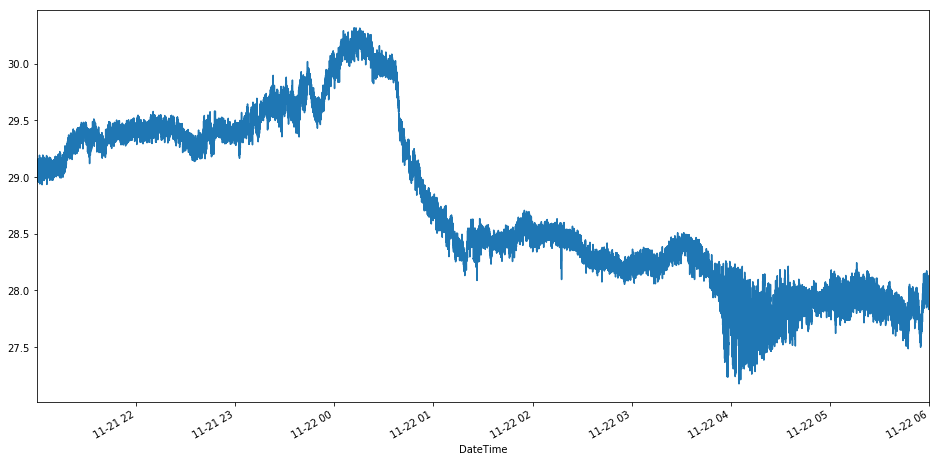

In [16]:
kt.SST_nocal.loc['2019-11-21 21:00:00':'2019-11-22 6:00:00'].plot(figsize=(16,8))

Tought to look at a timeseries of this length with the full sub-second resolution. Let's apply a centered rolling mean to tease out the longer-term trends:

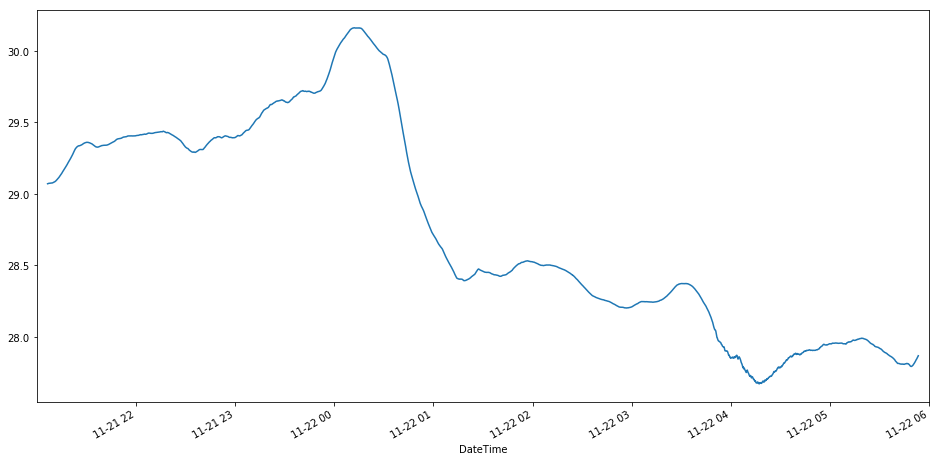

In [17]:
kt.SST_nocal.loc['2019-11-21 21:00:00':'2019-11-22 6:00:00'].rolling(1000,center=True).mean().plot(figsize=(16,8))

Timeline of events _At SPIP's location_: 
1. Winds pick up around 00:30, destroying the DWL and likely leading to the sudden decrease in SST measured by the KT-15s. 
2. Light rain begins around 01:15, and SPIP observes a cold surface layer (likely due to the heat flux associated with the wind increase). 
3. Then from 03:45-04:00, the rain rate increases greatly and a cold freshwater lens develops in the upper ~1.5m. We see that reflected in the KT15 data as well, a significant drop in the same time period. 
4. Unfortunately SPIP was pulled shortly after 4:00, but the KT15 data does suggest that the rain event did not last much longer than that. Perhaps we could use ship met data to corroborate the story of the storm passing. The Mitie makes observations again from 04:27-04:47, so that could also give us insight into the tail end of the event. 

**note that the ship was maneuvering throughout this entire event, we will have to be very careful about that**

**Do the same treatment as Dynamo for Falkor16+19 rain events (piece together rain onset times from public cat data)**

Read BAMS article (Chen & Moum) about DYNAMO and Laxague+Zappa article about rain event from 2016.

Should also refer to some SPURS work - Zappa to find

Katsaros 198X paper shows exactly how to generate the sky correction coefficients. Zappa 1998 Appendix also talks about this.

Add 9-11um instrument to toolbox (once Zappa finds igor function)

## Appendix 1: KT-15 Processing

We will follow the same importing steps multiple times, once for each experiment. Start by importing all the python packages we'll need, along with the custom functions contained in the module 'KT15_Toolbox.py'.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import numpy as np
import glob
from matplotlib import pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

from KT15_Toolbox import KT15_importraw, KT15_labcalibration, KT15_calibrate_skycorrect82

### - Falkor 2019 -

First, we import the raw data files (Level 0) from each experiment, and save the data as a collated netCDF (Level 1). This can take a while for a large dataset, so don't run this cell if you don't mean it.

In [3]:
#Falkor 2019: Takes ~7 minutes to run. 
KT15_importraw(data_folder = '..\Data\Level_0\Falkor19\KT15',
               output_path = '..\Data\Level_1\Falkor19\KT15', 
               sea_serial = 7417,
               sky_serial = 7409, 
               experiment = 'Falkor19')

Next we'll import calibration data acquired in the Lab while looking at a blackbody, and extract a linear fit from the data that allows us to calibrate our field measurements and increase their accuracy.

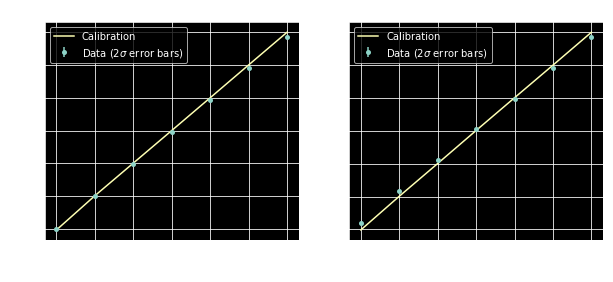

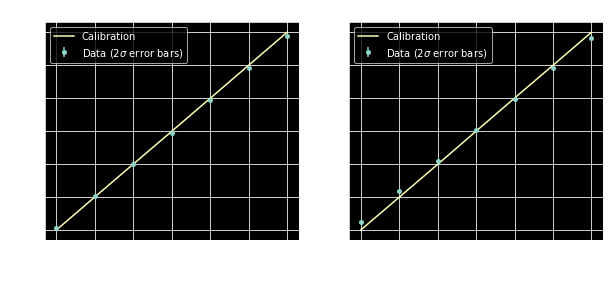

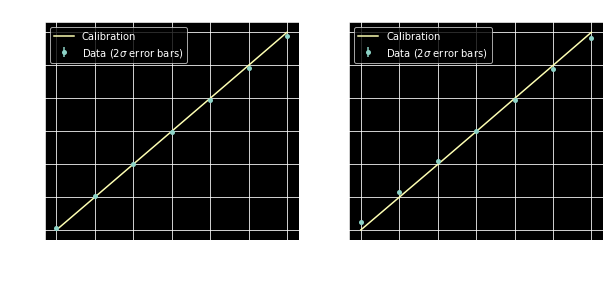

In [2]:
for cal_folder in glob.glob('../Data/Level_0/Falkor19/KT15_LabCalibrations/*'):  
    KT15_labcalibration(data_folder = cal_folder,
                        output_path = '../Data/Level_1/Falkor19/KT15_LabCalibrations', 
                        caltemps = [10,15,20,25,30,35,40])

We are ready to apply the lab calibrations and sky-correct the data:

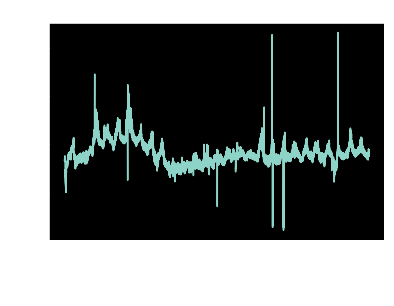

In [3]:
KT15_calibrate_skycorrect82(l1data_path = '../Data/Level_1/Falkor19/KT15/Falkor19_KT15_7417_7409.cdf',
                            output_path = '../Data/Level_3/Falkor19/KT15/',
                            cal_path = '../Data/Level_1/Falkor19/KT15_LabCalibrations/')

The KT-15 SST is now an L3 product, ready for use in science analysis in the body of the paper!

### - Falkor 2016 -

First, we import the raw data files (Level 0) from each experiment, and save the data as a collated netCDF (Level 1). This can take a while for a large dataset, so don't run this cell if you don't mean it.

In [ ]:
#Falkor 2016: Takes ~7 minutes to run. Note the sea and sky instruments are opposite from Falkor19
KT15_importraw(data_folder = '../Data/Level_0/Falkor16/KT15/',
               output_path = '../Data/Level_1/Falkor16/KT15/', 
               sea_serial = 7409,
               sky_serial = 7417, 
               experiment = 'Falkor16')

Next we'll import calibration data acquired in the Lab while looking at a blackbody, and extract a linear fit from the data that allows us to calibrate our field measurements and increase their accuracy.

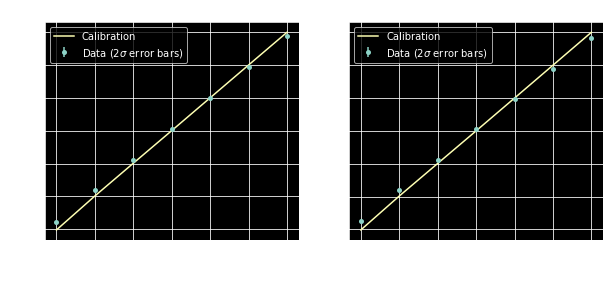

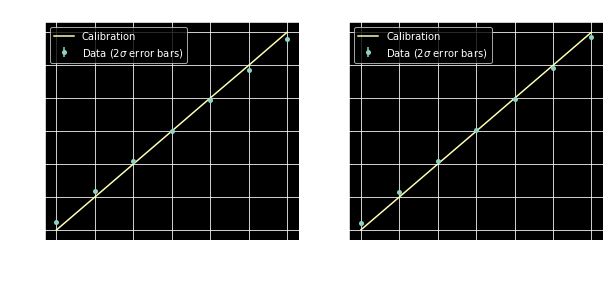

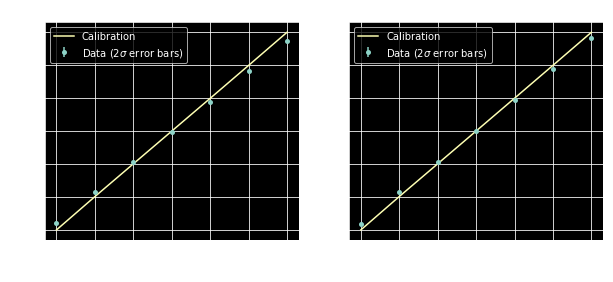

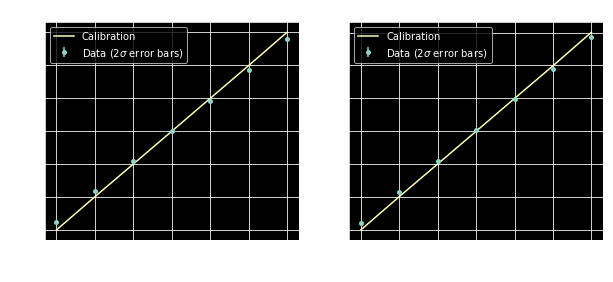

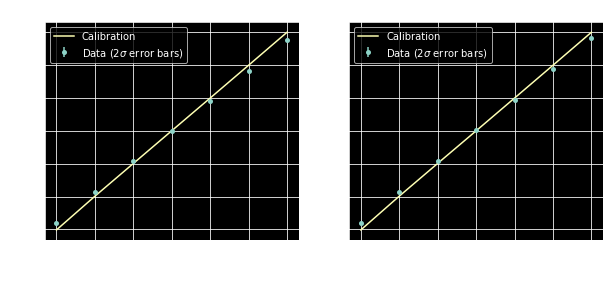

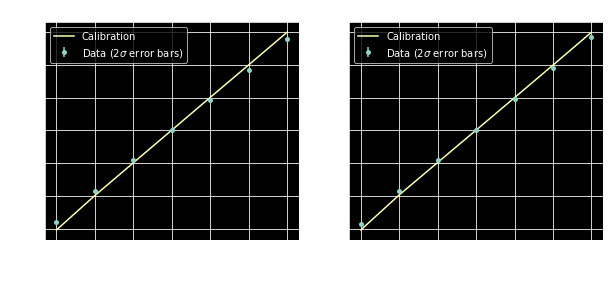

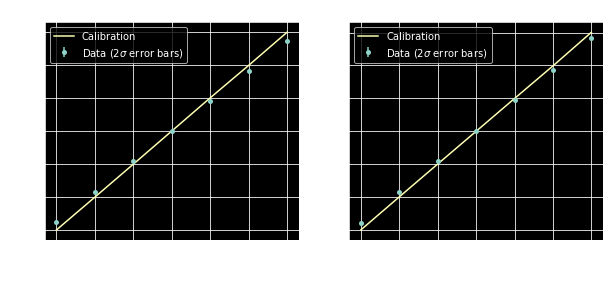

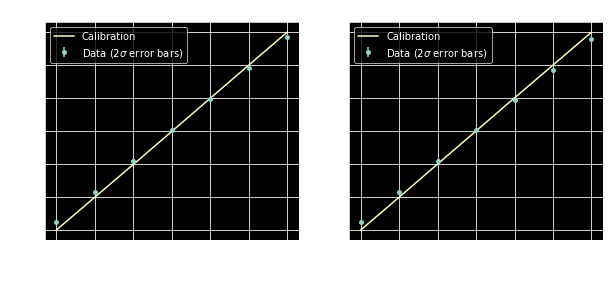

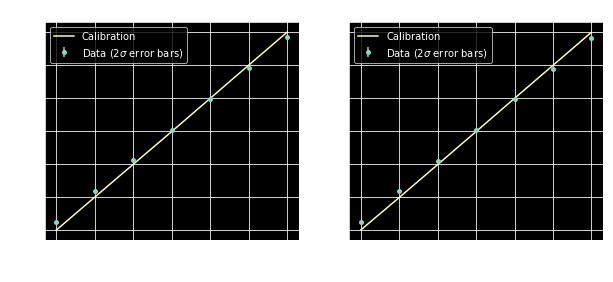

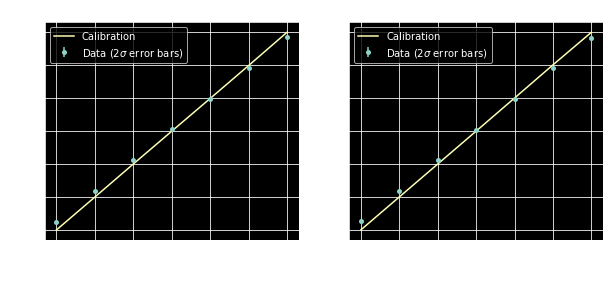

In [3]:
for cal_folder in glob.glob('../Data/Level_0/Falkor16/KT15_LabCalibrations/*'):  
    KT15_labcalibration(data_folder = cal_folder,
                        output_path = '../Data/Level_1/Falkor16/KT15_LabCalibrations', 
                        caltemps = [10,15,20,25,30,35,40])

We are ready to apply the lab calibrations and sky-correct the data:

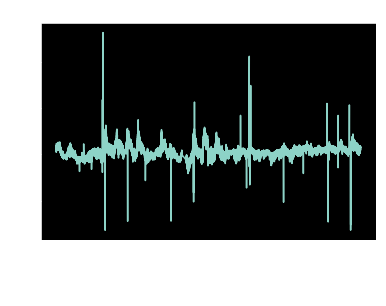

In [4]:
KT15_calibrate_skycorrect82(l1data_path = '../Data/Level_1/Falkor16/KT15/Falkor16_KT15_7409_7417.cdf',
                            output_path = '../Data/Level_3/Falkor16/KT15/',
                            cal_path = '../Data/Level_1/Falkor16/KT15_LabCalibrations/')

The KT-15 data is now a L3 product, ready for use in science analysis in the body of the paper!

### - Dynamo -

## Function Development